In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from sklearn.metrics import cohen_kappa_score     # pairwise κ
import krippendorff 
import itertools as it

/Users/mingbin/anaconda3/envs/gpu_env/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
seg_df      = pd.read_csv("summary_analysis.csv")   # one row per segment
breakdown   = pd.read_csv("aspect_breakdown.csv")   # method × attribute
overall     = pd.read_csv("aspect_overall.csv")     # one row per method

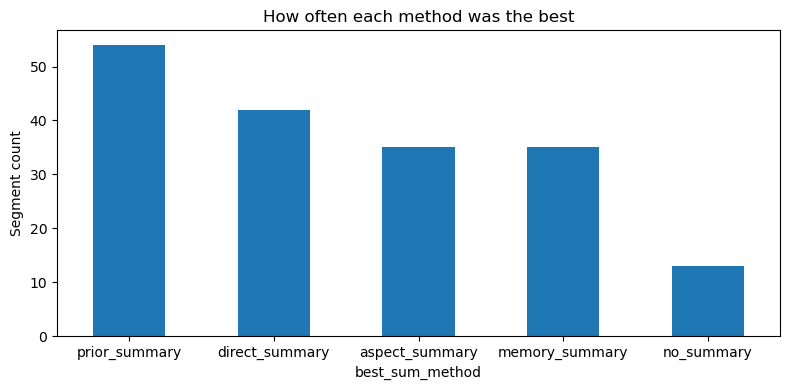

In [3]:
best_counts = seg_df["best_sum_method"].value_counts()

best_counts.plot.bar(rot=0, figsize=(8,4))
plt.title("How often each method was the best")
plt.ylabel("Segment count")
plt.tight_layout()
plt.show()


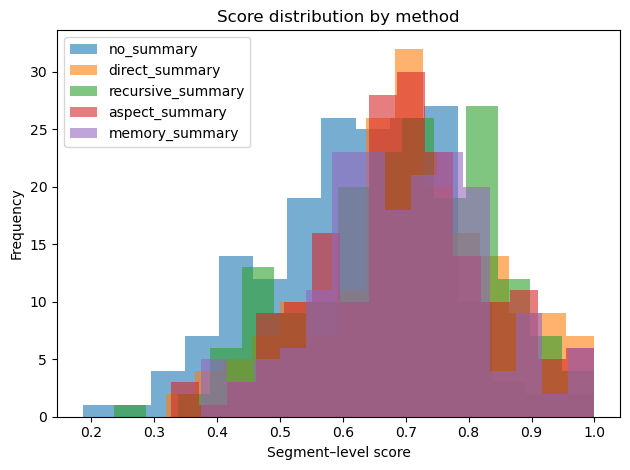

In [4]:
for col in ["no_summary", "direct_summary", "recursive_summary",
            "aspect_summary", "memory_summary"]:
    seg_df[col].plot.hist(alpha=0.6, bins=15, label=col)

plt.legend()
plt.xlabel("Segment–level score")
plt.title("Score distribution by method")
plt.tight_layout()
plt.show()

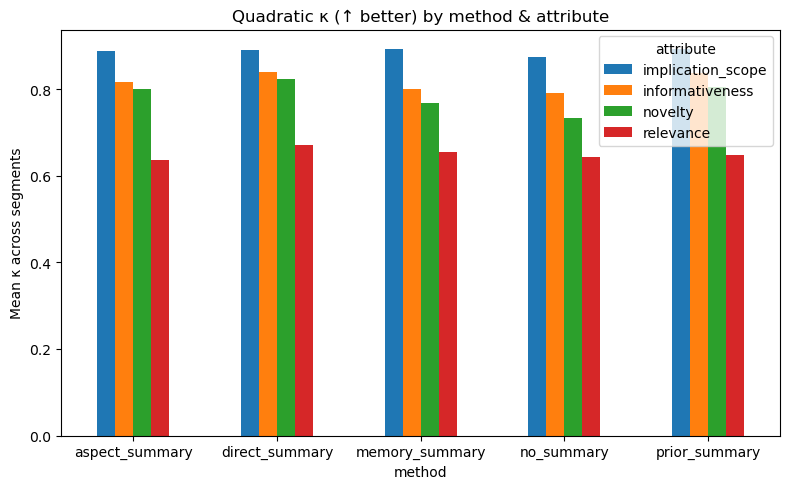

In [5]:
# Use quadratic-κ as the main “agreement” metric; swap to mse_mean if preferred.
pivot = breakdown.pivot(index="method", columns="attribute", values="kappa_mean")

pivot.plot.bar(figsize=(8,5))
plt.title("Quadratic κ (↑ better) by method & attribute")
plt.ylabel("Mean κ across segments")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

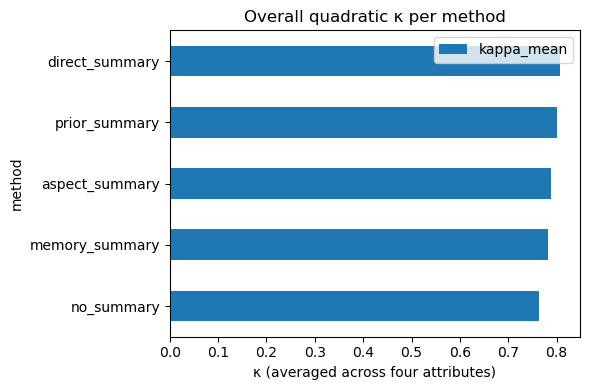

In [6]:
overall.sort_values("kappa_mean").plot.barh(
    x="method", y="kappa_mean", figsize=(6,4))
plt.title("Overall quadratic κ per method")
plt.xlabel("κ (averaged across four attributes)")
plt.tight_layout()
plt.show()



,method,attribute,avg,std,mse,kappa
0,aspect_summary,imsc,2.398,1.108,0.850,0.677
1,aspect_summary,info,2.033,1.030,0.616,0.684
2,aspect_summary,novo,1.912,1.063,0.744,0.625
3,aspect_summary,relv,3.146,1.238,0.913,0.684
4,direct_summary,imsc,2.408,1.100,0.906,0.654
5,direct_summary,info,2.088,1.024,0.686,0.651
6,direct_summary,novo,1.974,1.074,0.800,0.600
7,direct_summary,relv,3.237,1.162,0.953,0.650
8,human,imsc,2.292,1.179,NaN,NaN
9,human,info,1.876,0.932,NaN,NaN


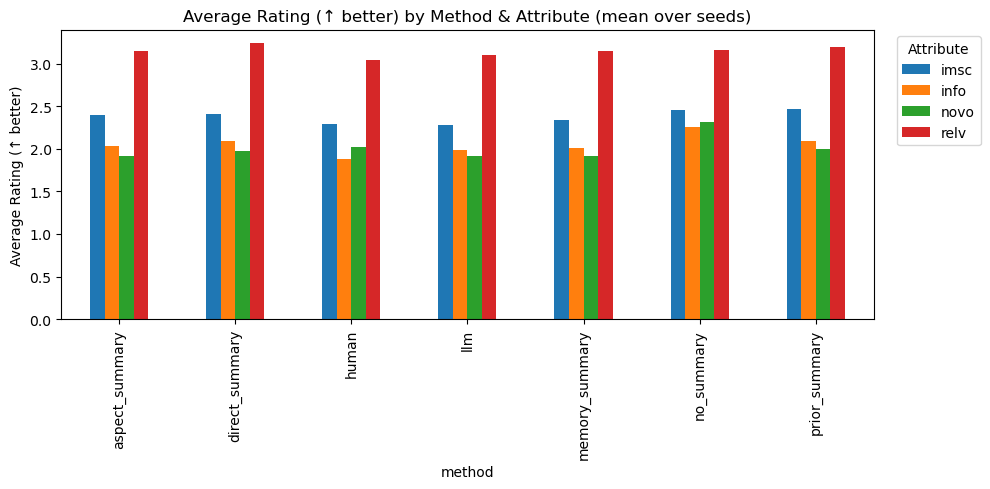

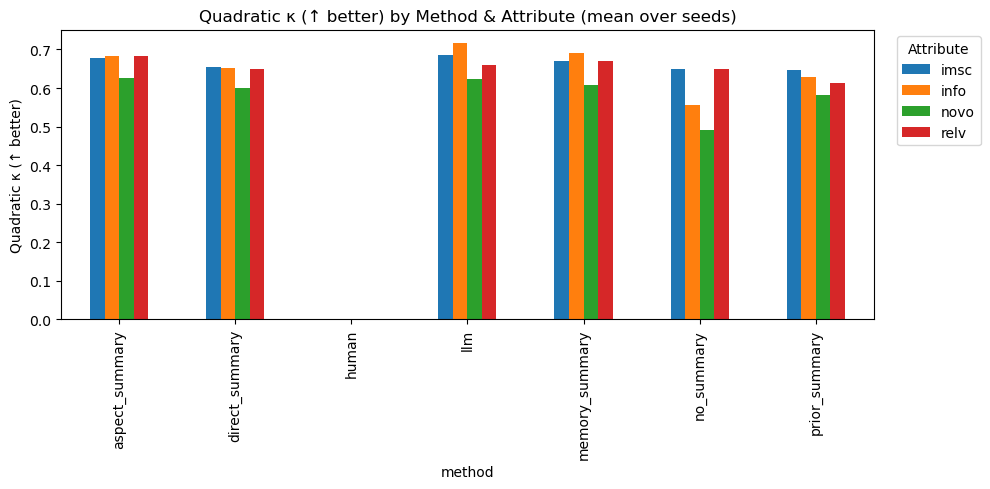

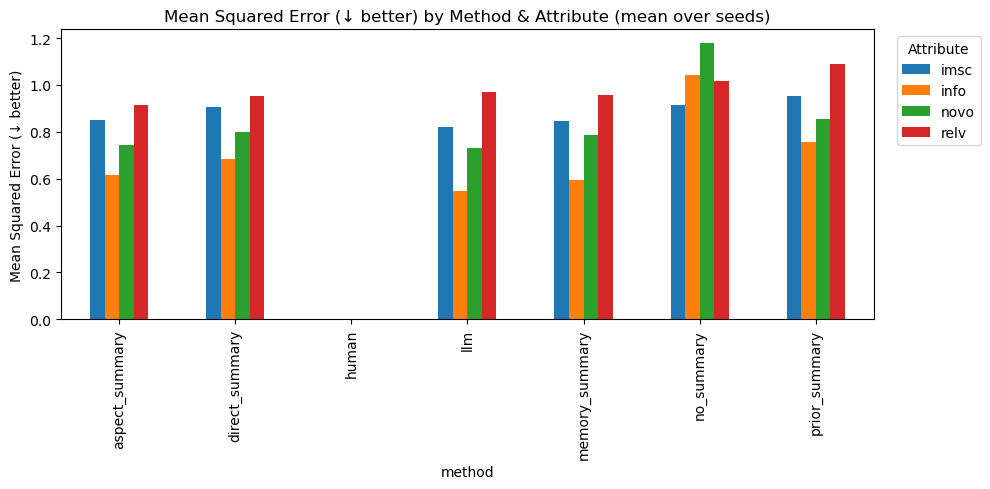

In [7]:
# 1)  ↩️  ADD or remove CSV paths here
csv_paths = [
    "records/sum_eval_22072025.csv",   # path to first run
    "records/sum_eval_29072025.csv",   # path to second run
    # "results_seed3.csv",
]

# 2) Load and concatenate
dfs       = [pd.read_csv(p) for p in csv_paths]
combined  = pd.concat(dfs, ignore_index=True)

# 3) Aggregate (mean across seeds) for each ⟨method, attribute⟩
agg = (
    combined
    .groupby(["method", "attribute"], as_index=False)
    .agg({
        "avg":   "mean",
        "std":   "mean",   # pooled std needs raw scores; here we average per-seed stds
        "mse":   "mean",
        "kappa": "mean"
    })
    .round(3)
)

display(agg)   # interactive table in Jupyter

# 4) Helper function for bar-chart grids
def plot_metric(metric_col, ylabel):
    pivot = agg.pivot(index="method", columns="attribute", values=metric_col)
    ax    = pivot.plot.bar(figsize=(10, 5))
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} by Method & Attribute (mean over seeds)")
    ax.legend(title="Attribute", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# 5) Three plots: average rating ↑, κ ↑, MSE ↓
plot_metric("avg",   "Average Rating (↑ better)")
plot_metric("kappa", "Quadratic κ (↑ better)")
plot_metric("mse",   "Mean Squared Error (↓ better)")

# (optional) save the aggregated table
agg.to_csv("aggregated_results.csv", index=False)

In [8]:
auto = agg[agg["method"] != "human"].copy()

# --------------------------------------------------------------------
# 3) Rank *within each attribute*:
#      • rank_mse   – ascending  (1 = lowest error)
#      • rank_kappa – descending (1 = highest κ)
# --------------------------------------------------------------------
auto["rank_mse"]   = auto.groupby("attribute")["mse"]  .rank(method="min", ascending=True)
auto["rank_kappa"] = auto.groupby("attribute")["kappa"].rank(method="min", ascending=False)

# Optional: a single combined rank (average of the two)
auto["rank_combined"] = auto[["rank_mse", "rank_kappa"]].mean(axis=1)

# --------------------------------------------------------------------
# 4) Create tidy grids for easy reading
# --------------------------------------------------------------------
def make_grid(rank_col):
    return (
        auto.pivot(index="attribute", columns="method", values=rank_col)
            .astype(int)
            .sort_index()
    )

grid_mse     = make_grid("rank_mse")
grid_kappa   = make_grid("rank_kappa")
grid_average = make_grid("rank_combined")

# --------------------------------------------------------------------
# 5) Overall (attribute-averaged) ranks per method
# --------------------------------------------------------------------
overall = (
    auto.groupby("method")[["rank_mse", "rank_kappa", "rank_combined"]]
        .mean()
        .rank(method="min")
        .astype(int)
        .rename_axis(index=None)
)

# --------------------------------------------------------------------
# 6) Display
# --------------------------------------------------------------------
print("=== Rank by Mean-Squared-Error (1 = best) ===")
print(grid_mse, "\n")

print("=== Rank by Quadratic κ (1 = best) ===")
print(grid_kappa, "\n")

print("=== Combined Rank (avg of MSE + κ) ===")
print(grid_average.astype(float).round(1), "\n")

print("=== Overall Method Ranks (attribute-averaged) ===")
print(overall)

=== Rank by Mean-Squared-Error (1 = best) ===
method     aspect_summary  direct_summary  llm  memory_summary  no_summary  \
attribute                                                                    
imsc                    3               4    1               2           5   
info                    3               4    1               2           6   
novo                    2               4    1               3           6   
relv                    1               2    4               3           5   

method     prior_summary  
attribute                 
imsc                   6  
info                   5  
novo                   5  
relv                   6   

=== Rank by Quadratic κ (1 = best) ===
method     aspect_summary  direct_summary  llm  memory_summary  no_summary  \
attribute                                                                    
imsc                    2               4    1               3           5   
info                    3               4    1  